In [1]:
import os
import json
import uuid
from workflow_manager import WorkflowManager, MongoWorkflow

In [2]:
# Load the sample input json for the request
example_file = os.path.join(".", "workflow_input_simple_branching_example.txt")
with open(example_file) as f:
    input_json = json.load(f)
#input_json

In [3]:
%%time
# Initialize the workflow class object and inputs
sim_id = str(uuid.uuid4())
debug = False
local = True
workflow = WorkflowManager(
    task_id=sim_id,
    sim_input=input_json["sim_input"],
    order=input_json["network"]["order"],
    sources=input_json["network"]["sources"],
    local=local,
    debug=debug
)
workflow.task_id

C:\Users\dsmith\Anaconda3\envs\qed-flask-dev\lib\site-packages\distributed\node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 59895 instead
  http_address["port"], self.http_server.port


Wall time: 6.1 s


'b2a23b18-fcab-49dc-9600-f69c01205a98'

In [4]:
workflow.scheduler

LocalCluster(b1efd175, 'tcp://127.0.0.1:59898', workers=4, threads=16, memory=127.76 GiB)

In [5]:
%%time
#TODO: Specify simulation level dependency tasks.
# input_json["simulation_dependencies"] = [{'name': NAME, 'url': URL, 'input': INPUT}]
# These dependencies will correspond to data retrieval tasks, performed by the Workflow manager prior to simulation execution tasks, to the HMS backend
# The results of these dependency tasks are stored in mongoDB by taskID, then passed along in the AQT workflow tasks by id
# The backend will be responsible for the logic and handling of the data
# When the backend merges the data into input (which will need to occur prior to merging the upstream segments) the backend will then save the 
# updated input (for potential reuse)

workflow.define_presim_dependencies(input_json["simulation_dependencies"])

Wall time: 0 ns


In [6]:
%%time
# Construct the dask graph from the catchment list
# Catchment dependencies behave the same way as simulation dependencies, but are only passed to the corresponding segment task and have the appropriate linking.
workflow.construct(input_json["comid_inputs"], input_json["catchment_dependencies"])

Wall time: 390 ms


6177452 : {}
6177450 : {}
6177476 : {'6177452': 'f951e5a9-9597-4352-ac2b-c57074bfbc37', '6177450': '6bf1acc5-aa26-4f74-b7be-1bd28da8d56a'}
6177474 : {}
6177558 : {'6177476': '38e44135-63c9-4c3e-959e-bdbb336b84a2', '6177474': 'e1b02a4c-c668-4b9c-b86f-dfc16ab03122'}
Delayed('6177558_083d47da-7ffe-48cf-9f72-32c91e7e6fdc')


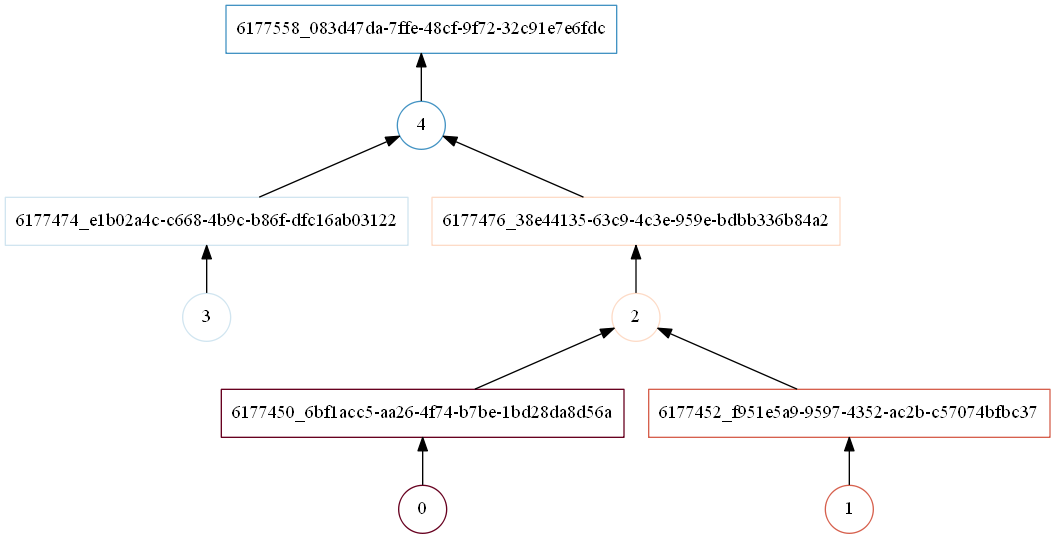

In [7]:
[print(f"{comid} : {c_id}") for comid, c_id in workflow.source_ids.items()]
print(workflow.pourpoint)
workflow.pourpoint.visualize("workflow-graph.png", color='order', verbose=True)

In [8]:
[print(f"{comid} : {c_id}") for comid, c_id in workflow.catchment_ids.items()]

6177452 : f951e5a9-9597-4352-ac2b-c57074bfbc37
6177450 : 6bf1acc5-aa26-4f74-b7be-1bd28da8d56a
6177476 : 38e44135-63c9-4c3e-959e-bdbb336b84a2
6177474 : e1b02a4c-c668-4b9c-b86f-dfc16ab03122
6177558 : 083d47da-7ffe-48cf-9f72-32c91e7e6fdc


[None, None, None, None, None]

In [9]:
%%time
# Request to get the simulation status from mongoDB
sim_status = MongoWorkflow.get_status(task_id=sim_id)
# del sim_status["input"]
sim_status

Wall time: 113 ms


{'_id': 'b2a23b18-fcab-49dc-9600-f69c01205a98',
 'type': 'workflow',
 'status': 'IN-PROGRESS',
 'update_time': '2021-06-17 14:50:35.370600',
 'message': None,
 'catchments': {'6177452': {'status': 'PENDING',
   'task_id': 'f951e5a9-9597-4352-ac2b-c57074bfbc37',
   'message': None,
   'update_time': '2021-06-17 14:50:35.206600',
   'dependencies': {}},
  '6177450': {'status': 'PENDING',
   'task_id': '6bf1acc5-aa26-4f74-b7be-1bd28da8d56a',
   'message': None,
   'update_time': '2021-06-17 14:50:35.287601',
   'dependencies': {}},
  '6177476': {'status': 'PENDING',
   'task_id': '38e44135-63c9-4c3e-959e-bdbb336b84a2',
   'message': None,
   'update_time': '2021-06-17 14:50:35.307600',
   'dependencies': {}},
  '6177474': {'status': 'PENDING',
   'task_id': 'e1b02a4c-c668-4b9c-b86f-dfc16ab03122',
   'message': None,
   'update_time': '2021-06-17 14:50:35.330601',
   'dependencies': {}},
  '6177558': {'status': 'PENDING',
   'task_id': '083d47da-7ffe-48cf-9f72-32c91e7e6fdc',
   'message': 

In [10]:
%%time
# Executes the workflow, based upon the constructed graph
workflow.compute()

Wall time: 53 s


In [ ]:
%%time
# Get the catchment status from mongoDB
catchment_id = "ac06a6b1-c290-43a5-b91b-a095bb9806b2"
catchment_status = MongoWorkflow.get_status(task_id=catchment_id)
# del catchment_status["input"]
catchment_status

In [ ]:
%%time
# Get the catchment data from mongoDB
catchment_data = MongoWorkflow.get_data(task_id=catchment_id)
# del catchment_data["output"]
catchment_data

In [ ]:
streamflow_dep_id = '0d669e33-d98b-4025-be93-c1eea228f4c7'
streamflow_data = MongoWorkflow.get_data(task_id=streamflow_dep_id)
streamflow_data